In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from template import *

# Step 1

Let's generate data

In [3]:
G = G2Model()
train_data = G.generate_sample(200)
test_data = G.generate_samaple(100)

In [4]:
mynet = MyNet(2, 10)
mynet.train(train_data)

In [5]:
G.plot_boundary(train_data, mynet)

Probably there is an error with labeling in **plot_boundary()** source code

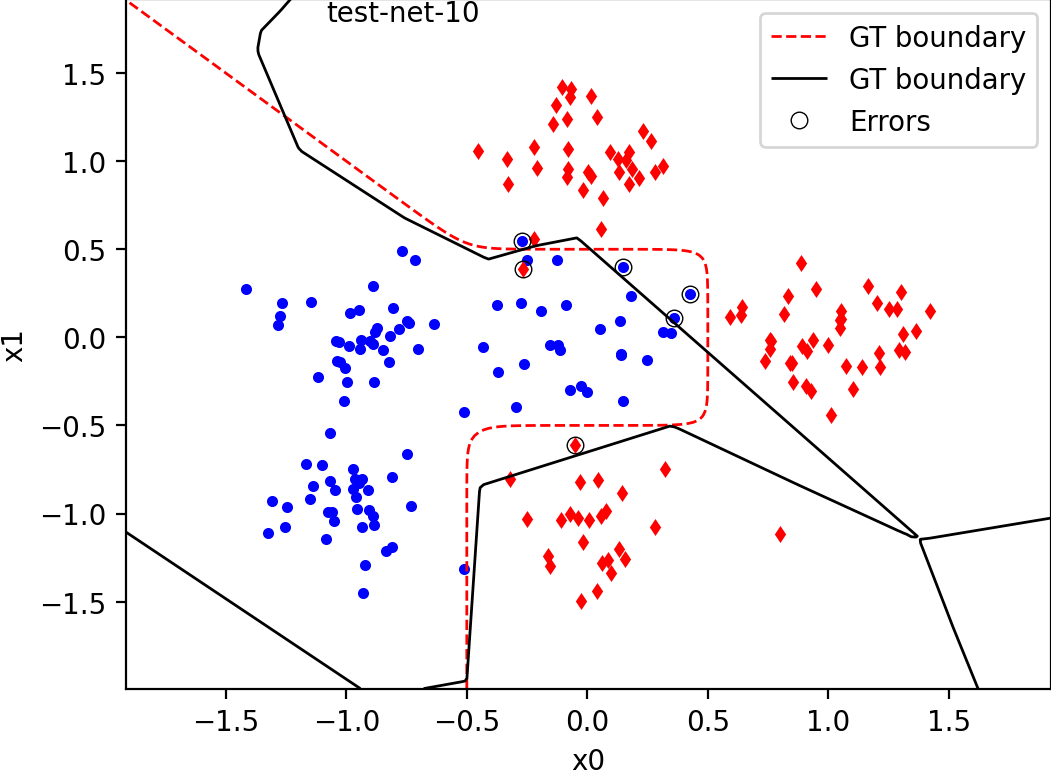

In [6]:
from IPython.display import Image
Image(filename='test-net-10.png') 

# Step 2

We will need some functions for statistics

In [7]:
def compute_accuracy(y, y_hat):
    return (y == y_hat).sum() / y.shape[0]

def compute_error(y, y_hat):
    return 1 - compute_accuracy(y, y_hat)

print(f'Train error: {compute_error(train_data[1], mynet.classify(train_data[0])):.3f}')

Train error: 0.030


In [8]:
print(f'Test error: {compute_error(test_data[1], mynet.classify(test_data[0])):.3f}')

Test error: 0.050


In [9]:
def mse(y, y_hat):
    return np.mean((y - y_hat) ** 2)

In [11]:
def compute_stats(model, train_data, test_data):
    stats = []
    
    for (x, y) in [train_data, test_data]:
        acc = compute_accuracy(y, model.classify(x))
        loss = mse(y, model.score(x))
        stats.extend([acc, loss])
    
    return stats

compute_stats(mynet, train_data, test_data)    

[0.97, 0.1583694156578731, 0.95, 0.23285637810881485]

A function for repeated trials

In [12]:
def compute_average_stats(train_data, test_data, hidden_units_bound, step, trials):
    hu_samples = range(1, hidden_units_bound, step)
    stats = np.zeros((len(hu_samples), 4))
    
    for i, hu in enumerate(hu_samples):
        hu_stats = np.zeros((trials, 4))
        
        for t in range(trials):
            mynet = MyNet(2, hu)
            mynet.train(train_data)
            hu_stats[t, :] = compute_stats(mynet, train_data, test_data)
            
        stats[i, :] = np.mean(hu_stats, axis=0)
        
    return stats

Let's compute the statistics

In [43]:
hidden_units_bound = 100
step = 1
trials = 100

train_data = G.generate_sample(40)
stats = compute_average_stats(train_data, test_data, hidden_units_bound, step, trials)
train_acc = stats[:, 0]
train_loss = stats[:, 1]
test_acc = stats[:, 2]
test_loss = stats[:, 3]

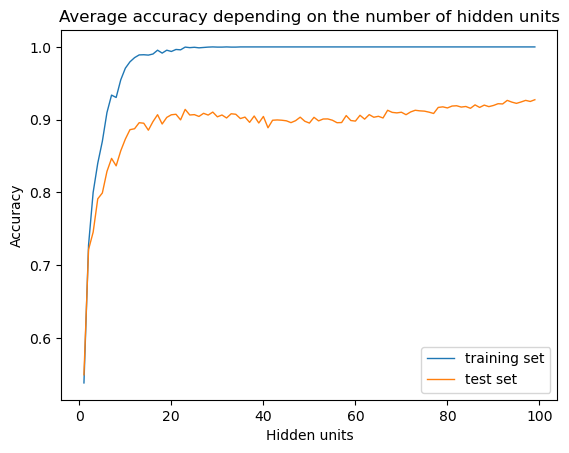

In [46]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

hidden_units = range(1, hidden_units_bound, step)

plt.plot(hidden_units, train_acc, label='training set')
plt.plot(hidden_units, test_acc, label='test set')
plt.xlabel('Hidden units')
plt.ylabel('Accuracy')
plt.title('Average accuracy depending on the number of hidden units')
plt.legend(loc="lower right");

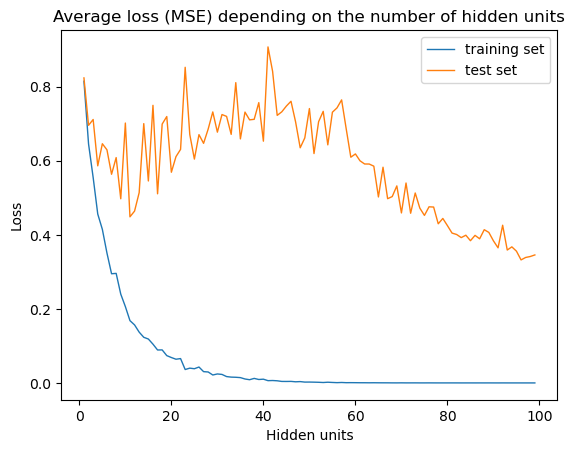

In [45]:
plt.plot(hidden_units, train_loss, label='training set')
plt.plot(hidden_units, test_loss, label='test set')
plt.xlabel('Hidden units')
plt.ylabel('Loss')
plt.title('Average loss (MSE) depending on the number of hidden units')
plt.legend(loc="upper right");

So as we can see from the pictures above, there is a classical U-shape for hidden size between 1 and 40. Not so much on the accuracy, but we can see the trend. 

What's an interesting is the trend after the hidden size above 40. Instead of overfitting, the model gets better and better on the testing set. So yeah, we are observing the double descent phenomenon.

# Step 3

A function for random flipping

In [73]:
from math import ceil

def random_flip(data, flip_prob):
    x, y = data
    n_flips = ceil(flip_prob * len(y))
    indices = np.random.choice(np.arange(len(y)), n_flips, replace=False)
    y[indices] *= -1
    return x, y

Let's add some noise

In [109]:
flip_prob = 0.05
train_data = random_flip(train_data, flip_prob)
test_data = random_flip(test_data, flip_prob)

stats = compute_average_stats(train_data, test_data, hidden_units_bound, step, trials)
train_acc = stats[:, 0]
train_loss = stats[:, 1]
test_acc = stats[:, 2]
test_loss = stats[:, 3]

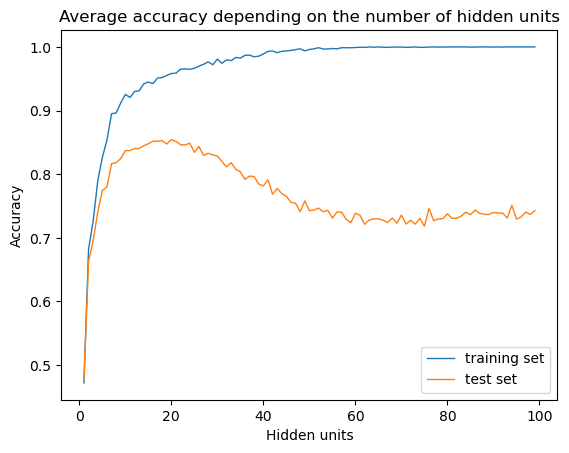

In [110]:
plt.plot(hidden_units, train_acc, label='training set')
plt.plot(hidden_units, test_acc, label='test set')
plt.xlabel('Hidden units')
plt.ylabel('Accuracy')
plt.title('Average accuracy depending on the number of hidden units')
plt.legend(loc="lower right");

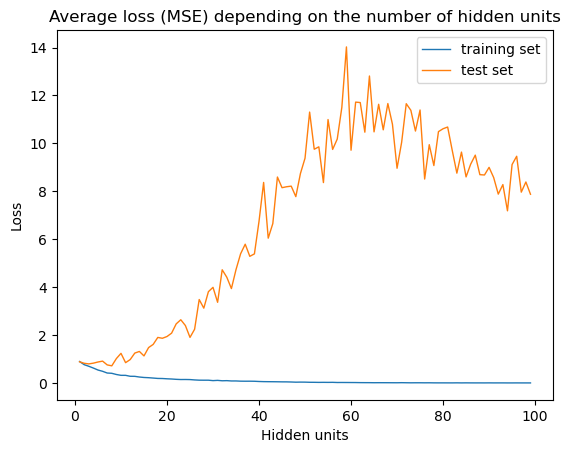

In [111]:
plt.plot(hidden_units, train_loss, label='training set')
plt.plot(hidden_units, test_loss, label='test set')
plt.xlabel('Hidden units')
plt.ylabel('Loss')
plt.title('Average loss (MSE) depending on the number of hidden units')
plt.legend(loc="upper right");

Finally, both peaks became more prominent, but especially the one on the accuracy plot. So yeah, this is it, I don't have much more to say :D